### 리뷰 파일 전처리

In [3]:
import pandas as pd
import numpy as np
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [5]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [6]:
train_data.drop_duplicates(subset=['document'], inplace=True) # 중복 제거
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [7]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  # 정규화
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [8]:
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    391
label         0
dtype: int64


In [9]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145791


In [10]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48995


In [11]:
stop_words = []  # 불용어

with open('stopwords.txt', 'r', encoding = 'utf-8') as f:
    lines = f.readlines()
    for line in lines:
        stop_words.append(line.rstrip('\n'))

In [12]:
okt = Okt()

X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stop_words] # 불용어 제거
    X_train.append(temp_X)

In [13]:
X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stop_words] # 불용어 제거
    X_test.append(temp_X)

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [15]:
# print(tokenizer.word_index)

In [16]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43493
등장 빈도가 2번 이하인 희귀 단어의 수: 24308
단어 집합에서 희귀 단어의 비율: 55.88945347527188
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.1217145185031674


In [17]:
vocab_size = total_cnt - rare_cnt + 1 # 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거. 0번 패딩 토큰을 고려하여 +1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19186


In [18]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [19]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [20]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [21]:
# train data 빈 샘플 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

144996
144996


In [22]:
# test data 빈 샘플 제거
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)
print(len(X_test))
print(len(y_test))

48682
48682


리뷰의 최대 길이 : 68
리뷰의 평균 길이 : 9.511345140555601


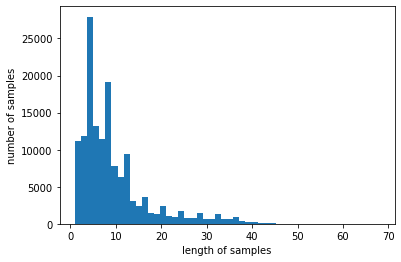

In [23]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [24]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [25]:
max_len = 40
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 99.70757814008662


In [26]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [27]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [28]:
print(X_train.shape)
print(X_test.shape)

print()

print(y_train.shape)
print(y_test.shape)

(144996, 40)
(48682, 40)

(144996, 2)
(48682, 2)


## BILSTM 모델링

In [29]:
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import Input, Model, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [30]:
import tensorflow as tf

class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [31]:
sequence_input = Input(shape=(max_len,), dtype='float32')
embedded_sequences = Embedding(vocab_size, 128, input_length=max_len)(sequence_input)

In [32]:
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
    (LSTM
     (128,
      dropout=0.3,
      return_sequences=True,
      return_state=True,
      recurrent_activation='relu',
      recurrent_initializer='glorot_uniform'))(embedded_sequences)

In [33]:
print(lstm.shape, forward_h.shape, forward_c.shape, backward_h.shape, backward_c.shape)

(None, 40, 256) (None, 128) (None, 128) (None, 128) (None, 128)


In [34]:
state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

attention = BahdanauAttention(128) # 가중치 크기 정의
context_vector, attention_weights = attention(lstm, state_h)
hidden = BatchNormalization()(context_vector)

output = Dense(2, activation='softmax')(hidden)
model = Model(inputs=sequence_input, outputs=output)
Adam = optimizers.Adam(lr=0.0001, clipnorm=1.)

es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accurary', mode='max', save_best_only=True)
model.compile(optimizer=Adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2455808     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 40, 256), (N 263168      embedding[0][0]                  
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256)          0           bidirectional[0][1]              
                                                                 bidirectional[0][3]          

In [36]:
history = model.fit(X_train, y_train, epochs=30, batch_size=60, validation_data=(X_test, y_test),  callbacks = [es, mc], verbose=1)

Epoch 1/30
2417/2417 [==============================] - 332s 137ms/step - loss: 0.4318 - accuracy: 0.7934 - val_loss: 0.3651 - val_accuracy: 0.8386
Epoch 2/30
2417/2417 [==============================] - 333s 138ms/step - loss: 0.3458 - accuracy: 0.8492 - val_loss: 0.3581 - val_accuracy: 0.8421
Epoch 3/30
2417/2417 [==============================] - 334s 138ms/step - loss: 0.3178 - accuracy: 0.8639 - val_loss: 0.3540 - val_accuracy: 0.8453
Epoch 4/30
2417/2417 [==============================] - 334s 138ms/step - loss: 0.2976 - accuracy: 0.8738 - val_loss: 0.3550 - val_accuracy: 0.8458
Epoch 5/30
2417/2417 [==============================] - 332s 137ms/step - loss: 0.2779 - accuracy: 0.8839 - val_loss: 0.3674 - val_accuracy: 0.8470
Epoch 6/30
2417/2417 [==============================] - 334s 138ms/step - loss: 0.2588 - accuracy: 0.8925 - val_loss: 0.3754 - val_accuracy: 0.8472
Epoch 7/30
2417/2417 [==============================] - 325s 134ms/step - loss: 0.2422 - accuracy: 0.9003 - val_

In [37]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

1522/1522 [==============================] - 23s 15ms/step - loss: 0.3905 - accuracy: 0.8478

 테스트 정확도: 0.8478


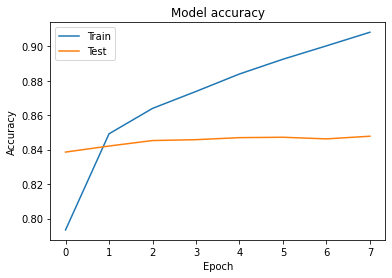

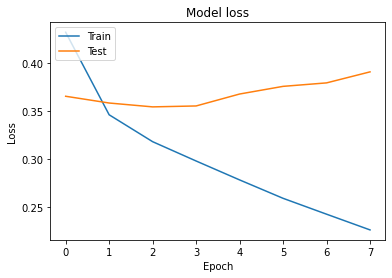

In [38]:
# 모델 시각화

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 학습 손실 값과 검증 손실 값을 플롯팅 합니다.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 키워드 파일 불러와 전처리

In [840]:
거리두기_1 = []
거리두기_2 = []
거리두기_3 = []
거리두기_4 = []
거리두기_5 = []
정부_1 = []
정부_2 = []
정부_3 = []
정부_4 = []
정부_5 = []
코로나_1 = []
코로나_2 = []
코로나_3 = []
코로나_4 = []
코로나_5 = []

with open('url_query/url_사회적_거리두기_01.txt', 'r', encoding = 'utf-8') as f:
    lines = f.readlines()
    for line in lines:
        거리두기_1.append(line.rstrip('\n'))     
        
with open('url_query/url_사회적_거리두기_02.txt', 'r', encoding = 'utf-8') as f:
    lines = f.readlines()
    for line in lines:
        거리두기_2.append(line.rstrip('\n'))
        
with open('url_query/url_사회적_거리두기_03.txt', 'r', encoding = 'utf-8') as f:
    lines = f.readlines()
    for line in lines:
        거리두기_3.append(line.rstrip('\n'))
        
with open('url_query/url_사회적_거리두기_04.txt', 'r', encoding = 'utf-8') as f:
    lines = f.readlines()
    for line in lines:
        거리두기_4.append(line.rstrip('\n'))
        
with open('url_query/url_사회적_거리두기_05.txt', 'r', encoding = 'utf-8') as f:
    lines = f.readlines()
    for line in lines:
        거리두기_5.append(line.rstrip('\n'))
        

with open('url_query/url_정부_01.txt', 'r', encoding = 'utf-8') as f:
    lines = f.readlines()
    for line in lines:
        정부_1.append(line.rstrip('\n'))

with open('url_query/url_정부_02.txt', 'r', encoding = 'utf-8') as f:
    lines = f.readlines()
    for line in lines:
        정부_2.append(line.rstrip('\n'))
        
with open('url_query/url_정부_03.txt', 'r', encoding = 'utf-8') as f:
    lines = f.readlines()
    for line in lines:
        정부_3.append(line.rstrip('\n'))
        
with open('url_query/url_정부_04.txt', 'r', encoding = 'utf-8') as f:
    lines = f.readlines()
    for line in lines:
        정부_4.append(line.rstrip('\n'))
        
with open('url_query/url_정부_05.txt', 'r', encoding = 'utf-8') as f:
    lines = f.readlines()
    for line in lines:
        정부_5.append(line.rstrip('\n'))
        
        
with open('url_query/url_코로나_01.txt', 'r', encoding = 'utf-8') as f:
    lines = f.readlines()
    for line in lines:
        코로나_1.append(line.rstrip('\n'))
        
with open('url_query/url_코로나_02.txt', 'r', encoding = 'utf-8') as f:
    lines = f.readlines()
    for line in lines:
        코로나_2.append(line.rstrip('\n'))
        
with open('url_query/url_코로나_03.txt', 'r', encoding = 'utf-8') as f:
    lines = f.readlines()
    for line in lines:
        코로나_3.append(line.rstrip('\n'))
        
with open('url_query/url_코로나_04.txt', 'r', encoding = 'utf-8') as f:
    lines = f.readlines()
    for line in lines:
        코로나_4.append(line.rstrip('\n'))
        
with open('url_query/url_코로나_05.txt', 'r', encoding = 'utf-8') as f:
    lines = f.readlines()
    for line in lines:
        코로나_5.append(line.rstrip('\n'))

In [841]:
거리두기_1 = pd.DataFrame(data=거리두기_1, columns=['거리두기_1'])
거리두기_2 = pd.DataFrame(data=거리두기_2, columns=['거리두기_2'])
거리두기_3 = pd.DataFrame(data=거리두기_3, columns=['거리두기_3'])
거리두기_4 = pd.DataFrame(data=거리두기_4, columns=['거리두기_4'])
거리두기_5 = pd.DataFrame(data=거리두기_5, columns=['거리두기_5'])

정부_1 = pd.DataFrame(data=정부_1, columns=['정부_1'])
정부_2 = pd.DataFrame(data=정부_2, columns=['정부_2'])
정부_3 = pd.DataFrame(data=정부_3, columns=['정부_3'])
정부_4 = pd.DataFrame(data=정부_4, columns=['정부_4'])
정부_5 = pd.DataFrame(data=정부_5, columns=['정부_5'])

코로나_1 = pd.DataFrame(data=코로나_1, columns=['코로나_1'])
코로나_2 = pd.DataFrame(data=코로나_2, columns=['코로나_2'])
코로나_3 = pd.DataFrame(data=코로나_3, columns=['코로나_3'])
코로나_4 = pd.DataFrame(data=코로나_4, columns=['코로나_4'])
코로나_5 = pd.DataFrame(data=코로나_5, columns=['코로나_5'])

In [942]:
거리두기_5.nunique()

거리두기_5    643
dtype: int64

In [943]:
거리두기_5['거리두기_5'] = 거리두기_5['거리두기_5'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
거리두기_5['거리두기_5'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
거리두기_5=거리두기_5.dropna(how='any') # Null 값 제거

In [944]:
# okt, 불용어 처리

X_train = []

for sentence in 거리두기_5['거리두기_5']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stop_words] # 불용어 제거
    X_train.append(temp_X)

In [945]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [946]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 3410
등장 빈도가 2번 이하인 희귀 단어의 수: 2452
단어 집합에서 희귀 단어의 비율: 71.90615835777126
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 24.570264765784113


In [947]:
vocab_size = total_cnt - rare_cnt + 1 # 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거. 0번 패딩 토큰을 고려하여 +1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 959


In [948]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)

In [949]:
len(X_train)

642

In [950]:
X_train = pad_sequences(X_train, maxlen = max_len)

In [951]:
X_train.shape

(642, 40)

## 위에서 만든 모델로 예측하고 결과 합치기

In [952]:
result = model.predict(X_train)

In [953]:
result[:5]

array([[0.35043126, 0.6495688 ],
       [0.07730507, 0.9226949 ],
       [0.09771327, 0.9022867 ],
       [0.5542853 , 0.44571474],
       [0.46863377, 0.5313663 ]], dtype=float32)

In [954]:
distance_5 = pd.DataFrame(data = result, columns = ['0', '1'])

In [955]:
distance_5['예측값'] = distance_5.idxmax(axis=1)

In [956]:
print(distance_5.shape)
print(거리두기_5.shape)

(642, 3)
(642, 1)


In [958]:
거리두기_5월 = pd.concat([거리두기_5, distance_5['예측값']], axis = 1)

In [959]:
거리두기_5월.isnull().sum()

거리두기_5    1
예측값       1
dtype: int64

In [960]:
거리두기_5월 = 거리두기_5월.dropna(how='any')

## 사회적 거리두기 데이터 결과

In [895]:
거리두기_1월

,거리두기_1,예측값
0,그래서 이 시대의 키 워드는 정의인가보다 각 분야의 정의로운 전문가들이 소신있는...,1
1,정의가 나와 생각을 달리하는 자를 공격하기 위한 수단으로 오염되면서자기 자신의 정의...,1
3,ㅋㅋㅋ자한당에서도 내부고발 부탁해,0
4,안전한 원전두고무슨 똥 고집인지이것도 탄핵의 한 이유가될것이다,1


In [911]:
거리두기_2월

,거리두기_2,예측값
0,호남빼곤 이번총선 민주당쉽지 않을듯 이상황에도 낙관하면 진짜 뇌가없다고 봐야지,0
1,ㅎㅎㅎ 이 아저씨는 잘 모른다 초기에 ㅇㅔ 나와서 공기 감염이 불가능하다고 얘기하고...,0
3,메르스보다 잘막았다는 개소리는 더 이상 하지마라 중국 하수인 문재앙씨,0
4,그게 무슨상관이니,0
5,사이비 종교집단이 나라 말아먹은 사례로 역사에 길이 길이 남겠네 숨어 다니는 이 악...,0
...,...,...
62,이정도면ㅋㅋ놀면서 늦장부린 박근혜보다 초기때부터 오바싼 문정권이 더 못한거네ㅋㅋㅋ다...,0
63,저사람들중 코로나 걸려도 아마 숨길것같다 시위나갔다가 코로나걸린거알면 난리나니까,0
64,압수숙색할 공권력은 있는데 입국 금지는 안하냐,0
65,웃기고 있네 온오프라인 통들어 숙대생들이 얼마나 반대했는데 이걸 언론탓으로 몰아가네...,1


In [926]:
거리두기_3월

,거리두기_3,예측값
0,개학 연기하는동안 아무런 대책도 하지 않은건지 애들만 덩그러니 집에서 온라인수업을 ...,0
2,초중고 개학 전까진 대학도 문 열면 안 되지 그럼 지금까지 고생한 거 싹 다 물거...,0
3,이렇게 전파력센데 좀 입국이라도 좀 빨리막고 격리좀시키지 진짜답없다,0
4,회사가 미국 갔다온거 아는데 강제로 출근 시켰니,1
5,중국 우한 폐렴이 사람들을 꼼짝 못하게 하네요중국의 저주라고 해야 할지아이러니하게 ...,1
...,...,...
399,우이교 벚꽃은 통제 안하니 보실분 보러가세요어제 사람 많더라고요,0
400,우리나라도 집단적인 직접 예배 강행 시 차원에서의 고발 벌금 부과뿐만 아니라 이렇게...,0
401,이말도 틀린것이다 다른사건은 모르겟고 콜롬비아에서온 광주 신천지확진자 명이 일주일전...,0
402,주가올릴생각만 가득한것들,0


In [941]:
거리두기_4월

,거리두기_4,예측값
0,돈주고두 못 사는 강의 듣고 갑니다,1
1,그동안 영화관에 방문하지 못해 아쉬움이 많이 컸었는데 다시 오픈을 하게 된다는 소식...,1
2,중국 제외한 다른 아시아인들은 대체 뭔 죄냐,1
3,대구시민인데요 지금까지 단 한번도 확진자 관련 동선같은거 제공받은거 없어요 초반 수...,1
4,방심 할 때가 아닌것 같다 아직 기레기들이 않걸렸다,0
...,...,...
485,테라 광고는 발전이 없네 맨날 똑같은데 왜 새로 만드는건지,1
486,도데체 다음달 언제냐고 날짜를 말혀라고 이러다 시간다 가것다,1
487,가능한 밀폐된 식당 실내 관광지 접근은 자제해 주시고 카페에 머무를때에도 마스크 착...,1
488,무슨 부산은 회색 하늘입니다,1


In [961]:
거리두기_5월

,거리두기_5,예측값
0,문빠들은 이딴거 관심없어요,1
1,개장하지마 학교도 제대로 못가는데 무슨 해수욕이야 얼어주글,1
2,면역력이 약한 어린이들이 많이 모여있는 곳에는 마스크가 계속 필요할 텐데 배부를 해...,1
3,대출 앵꼬 다음은 뭐 집팔고 노숙이야 집값 천년만년 우상향일줄 알지ㅋㅋㅋ,0
4,이와중에 해운대 개장하냐 ㅋㅋㅋ,1
...,...,...
637,정부가 슈퍼전파자,0
638,ㅋㅋㅋ 대책없이 그냥 세금으로 꼬라박았더니 소상공인들은 가격올려서 꿀꺽질ㅋㅋ 이게 ...,1
639,방역당국 더이상 쉬쉬하다가는 우리애들 큰일난다 ㅡㅡ 문죄인 눈치보지 말고 확실히해라,1
640,애들 좀 살립시다방역은 누가 지어낸 개소리인지,0


In [962]:
거리두기_긍정 = pd.DataFrame(index = range(0, 5), 
                      columns = ['predict',
                                 'month'])
                        
거리두기_부정 = pd.DataFrame(index = range(0, 5),
                      columns = ['predict',
                                 'month'])  

In [963]:
거리두기_부정['predict'].iloc[0:] = (거리두기_1월['예측값'] == '1').sum(axis=0)
거리두기_부정['predict'].iloc[1:] = (거리두기_2월['예측값'] == '1').sum(axis=0)
거리두기_부정['predict'].iloc[2:] = (거리두기_3월['예측값'] == '1').sum(axis=0)
거리두기_부정['predict'].iloc[3:] = (거리두기_4월['예측값'] == '1').sum(axis=0)
거리두기_부정['predict'].iloc[4:] = (거리두기_5월['예측값'] == '1').sum(axis=0)

거리두기_긍정['predict'].iloc[0:] = (거리두기_1월['예측값'] == '0').sum(axis=0)
거리두기_긍정['predict'].iloc[1:] = (거리두기_2월['예측값'] == '0').sum(axis=0)
거리두기_긍정['predict'].iloc[2:] = (거리두기_3월['예측값'] == '0').sum(axis=0)
거리두기_긍정['predict'].iloc[3:] = (거리두기_4월['예측값'] == '0').sum(axis=0)
거리두기_긍정['predict'].iloc[4:] = (거리두기_5월['예측값'] == '0').sum(axis=0)

In [964]:
month = ['jan','feb','mar','apr','may']

거리두기_긍정['month'].iloc[:] = month
거리두기_부정['month'].iloc[:] = month

In [967]:
거리두기_긍정

,predict,month
0,1,jan
1,43,feb
2,203,mar
3,254,apr
4,327,may


In [968]:
거리두기_부정

,predict,month
0,3,jan
1,23,feb
2,200,mar
3,235,apr
4,314,may


(0.0, 400.0)

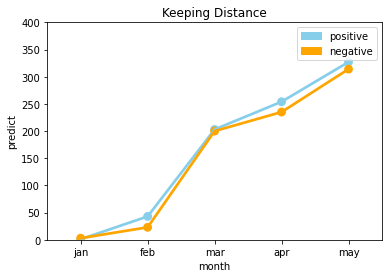

In [973]:
import seaborn as sns
import matplotlib.patches as mpatches

plt.title('Keeping Distance')
sns.pointplot(x='month', y='predict', data = 거리두기_긍정, color = 'skyblue', label = 'positive')
positive = mpatches.Patch(color='skyblue', label='positive')
plt.legend(handles = [positive])

sns.pointplot(x='month', y='predict', data = 거리두기_부정, color = 'orange', label = 'negative')
negative = mpatches.Patch(color='orange', label='negative')
plt.legend(handles = [positive, negative])

plt.ylim(0, 400)

## 코로나 키워드 데이터 결과

In [433]:
코로나_1월

,코로나_1,예측값
0,다행이네요 근데 희한하게 하필 많고많은 직업중에 어린이집교사들이 ㅜㅜ,1
1,한동안 미세먼지는 없겠구만,1
2,차 전세기에 못탄 한국인 명 있었다는데 그심정은 말로 표현 못할거같아요 한국으로 ...,0
3,도대체 이분들 데리러 가고 오고가 왜 속보며 왜이리 호들갑이냐 우한서 들어온 천명 ...,0
4,번째확진자도 음성이다해서 격리해제로퇴원시켰지만 그뒤로 안좋아져서다시 확진자로 되었다...,0
...,...,...
813,결국 번때문에 이 사단이 나는구나,0
814,힘들겠지만 이겨내기를 바랍니다,0
815,지랄을 하세요 대기업 꼬봉 세키들,1
816,일이 디데이였다 그 때라도 선제적 조치를 취했어야 한다 불안해하지 말라고 양산 휴가...,0


In [452]:
코로나_2월

,코로나_2,예측값
0,한동안 미세먼지는 없겠구만,0
1,차 전세기에 못탄 한국인 명 있었다는데 그심정은 말로 표현 못할거같아요 한국으로 ...,0
2,다행이네요 근데 희한하게 하필 많고많은 직업중에 어린이집교사들이 ㅜㅜ,1
3,도대체 이분들 데리러 가고 오고가 왜 속보며 왜이리 호들갑이냐 우한서 들어온 천명 ...,0
4,도대체 이분들 데리러 가고 오고가 왜 속보며 왜이리 호들갑이냐 우한서 들어온 천명 ...,0
...,...,...
4116,힘들겠지만 이겨내기를 바랍니다,1
4117,힘들겠지만 이겨내기를 바랍니다,1
4119,지랄을 하세요 대기업 꼬봉 세키들,1
4120,일이 디데이였다 그 때라도 선제적 조치를 취했어야 한다 불안해하지 말라고 양산 휴가...,1


In [472]:
코로나_3월

,코로나_3,예측값
0,정후보가 당선되면 인천은 촌구석임을 스스로 인정하는건가,1
2,계속 주변에서 추가 확진 소식이 들려오니 불안하고 두렵네요 이 코로나바이러스가 우리...,0
3,이 시국에 여행을 왜가ㅡㅡ생각이없는듯,0
4,푸틴도 중공역병에 뒤지는겨ㅋㅋㅋㅋㅋㅋㅋ,1
5,유럽은 우리보다 주 늦게 미국은 주 늦게 적극적인 검사를 시작했는데 지금 이렇게 결...,0
...,...,...
430,클로로퀸 부작용이 의사처방없이 먹은거랑 어류용 클로로퀸 먹은거랑 과다복용이런거 아닌...,0
431,우스운 한수원 행태인가 전 직원에게 강압적인 자율적반납을 한다고 한다 이런 것은 아...,0
432,광주시 시장은 다음 새로운 분으로 교체 건의 예정아니면 이사가던가 해야겠다,0
433,간병인들을 조사하라고왜 중국인간병인에대해서는 일체언급이 없는거냐 참 아이러니 하다,1


In [489]:
코로나_4월

,코로나_4,예측값
0,이런시국에 코스피가 오르는건 무지한 개미때문인가,1
1,이름도 재수 없네,0
2,저게 우리가 그토록 갈망하던 최고의 선진국에 로망이였나 개가 죽어도 저런식으론 처리...,0
3,역시 독일은 다르네 그래야 이런 일 또 생기면 잘 할테니까ㅋ,0
4,경기가 안 좋으면 원래 중고거래가 잘 되는 법 슬픈 현실이다,1
...,...,...
636,가는건 좋은데 피해는 안주고 왔으면 좋겠다행여나 명이라도 나오는 순간엔 손해배상들...,0
637,돌려서 본인 힘이라고 말하네 사망자 천명 이상 나면 나라가 힘없어서 그러나 미국 프...,0
638,장가 니가 국회의원이라고 면상들고 나오는건 양심이 있는거야,1
639,집에있어라 많이 좋아지긴했는데 어째 언론인이라는 인간이 이런 기사를 쓰지,0


In [506]:
코로나_5월

,코로나_5,예측값
0,양파농장에서 일하려고 보트까지사고 궂이 밀입국을 했다라,0
1,완전 감시사회 진입한다는 건대 중국과 뭐가 다르다는거냐,1
2,정상회의에 독일 빼고는 프랑스를 포함해서 대부분의 국가들이 참여 의사를 밝혔고 대...,1
3,질병을 정치로 이용해먹고 있는 모습을 보면서 화가난다 학부모 반대에도 학교는 억지로...,1
4,지나가는 길에 개가 짖어서 뭔가하고 봄,1
...,...,...
572,대깨문들은 당연히 안쳤겠지,1
573,이시국에 예배는 제발좀 집에서 해라,0
574,맨날 똑같은 사진이네요 도청 사진 다른 각도로 다시 컷,0
575,내일부터 만개의 건설현장사업장을 검사 해서 코로나가 있나 없나 점검하는 우리나라가 ...,0


In [723]:
코로나_긍정 = pd.DataFrame(index = range(0, 5), 
                      columns = ['predict',
                                 'month'])
                        
코로나_부정 = pd.DataFrame(index = range(0, 5),
                      columns = ['predict',
                                 'month'])                        

In [724]:
코로나_부정['predict'].iloc[0:] = (코로나_1월['예측값'] == '1').sum(axis=0)
코로나_부정['predict'].iloc[1:] = (코로나_2월['예측값'] == '1').sum(axis=0)
코로나_부정['predict'].iloc[2:] = (코로나_3월['예측값'] == '1').sum(axis=0)
코로나_부정['predict'].iloc[3:] = (코로나_4월['예측값'] == '1').sum(axis=0)
코로나_부정['predict'].iloc[4:] = (코로나_5월['예측값'] == '1').sum(axis=0)

코로나_긍정['predict'].iloc[0:] = (코로나_1월['예측값'] == '0').sum(axis=0)
코로나_긍정['predict'].iloc[1:] = (코로나_2월['예측값'] == '0').sum(axis=0)
코로나_긍정['predict'].iloc[2:] = (코로나_3월['예측값'] == '0').sum(axis=0)
코로나_긍정['predict'].iloc[3:] = (코로나_4월['예측값'] == '0').sum(axis=0)
코로나_긍정['predict'].iloc[4:] = (코로나_5월['예측값'] == '0').sum(axis=0)

In [680]:
코로나_긍정.head()

,predict,month
0,402,NaN
1,1941,NaN
2,197,NaN
3,284,NaN
4,276,NaN


In [725]:
month = ['jan','feb','mar','apr','may']

코로나_긍정['month'].iloc[:] = month
코로나_부정['month'].iloc[:] = month

In [726]:
코로나_긍정.head()

,predict,month
0,415,jan
1,1162,feb
2,236,mar
3,356,apr
4,299,may


In [727]:
코로나_부정.head()

,predict,month
0,402,jan
1,1941,feb
2,197,mar
3,284,apr
4,276,may


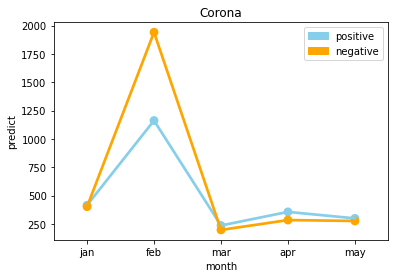

In [970]:
import seaborn as sns
import matplotlib.patches as mpatches

plt.title('Corona')
sns.pointplot(x='month', y='predict', data = 코로나_긍정, color = 'skyblue', label = 'positive')
positive = mpatches.Patch(color='skyblue', label='positive')
plt.legend(handles = [positive])

sns.pointplot(x='month', y='predict', data = 코로나_부정, color = 'orange', label = 'negative')
negative = mpatches.Patch(color='orange', label='negative')
plt.legend(handles = [positive, negative])


## 정부 키워드 데이터 결과

In [763]:
정부_1월

,정부_1,예측값
0,한동안 미세먼지는 없겠구만,0
1,차 전세기에 못탄 한국인 명 있었다는데 그심정은 말로 표현 못할거같아요 한국으로 ...,1
2,도대체 이분들 데리러 가고 오고가 왜 속보며 왜이리 호들갑이냐 우한서 들어온 천명 ...,0
3,만 달라짜리 비행편이다 자국민 데려오겠다는데 뇌물을 그렇게 갖다바쳐야 겨우 허가해주...,1
4,집으로 돈 버는시대는 끝네야함제주도 집값은 아주비정상,1
...,...,...
830,이왕 오신거 조심히 제발 조심히 있다 가세요격리 잘 해주시고 단독행동 하시는 불상사...,0
831,비용을 쓰더라도 급하면 하는거고 평소에까지 적용하려면 사람을 더구해야지,1
832,마스크 가격 규제해라ㅡㅡ 배이상 가격오른게 말이되냐 중국에 퍼주지말고 한국에 쫌 주...,1
833,당신들만 마음이 놓이는 겁니다,0


In [781]:
정부_2월

,정부_2,예측값
0,도와주고 지켜줘도 스스로 도모할수없는 아프간정부를 더이상 무의미한 희생으로만 감당하...,0
1,하기만 해봐라,0
2,현대판 매국노 능지처참 해라,0
4,대한민국 반으로 가른 중국이다 북한이라는 독재국가가 있게 해준 중국이다 도움은 일절...,0
5,중국인 막나 안막나 경제망하는건똑같은데ㅉㅉ,0
...,...,...
1320,지금 마스크도 못구하고 있는데 다음주 개학이라니 어떻게 아이를 내보낼 수 있다는 말...,0
1321,언젠가 보수당이 집권할텐데 그 때는 중국에게 어떻게 하는지 봅시다,1
1322,초기 대응 실패 중국 눈치보니라 북한도 초기에 금지한걸 계속 미룸 문재앙 가짜뉴스 ...,1
1323,신천지 너거들은 천벌을받을거다지옥에나가라,0


In [796]:
정부_3월

,정부_3,예측값
0,천명이 안정기정말큰일이군요,0
1,힘 내자 이제 불안해하지 말고 이겨내야한다,0
2,그럼 한국들어와서 투표하든가 이시국에 어떻게 투표소 설치하라고 이런걸 공권력이라 우기냐,1
3,인천 시장님 알흠답습니다이번에 다시 재번복 했는데 상위프로만 인천시에서 주고 일반서...,0
4,개학 연기하는동안 아무런 대책도 하지 않은건지 애들만 덩그러니 집에서 온라인수업을 ...,1
...,...,...
706,자국민 출국금지도시켜줘라 한김에,0
707,싸가지 없는 벳남태극기로 코로나바이러스 그려가며 빈정대던 할 나쁜 넘들 일체 지원마...,1
708,차원이 다른 대통령 후보 안대표님 응원합니다,1
709,초등학년이 어떻게 온라인 수업을 하죠,0


In [811]:
정부_4월

,정부_4,예측값
0,역시 독일은 다르네 그래야 이런 일 또 생기면 잘 할테니까ㅋ,0
2,퇴직금없애라 대보험에 주휴수당에 일한만큼 가져가야지 복지를 국가서 해야지 왜 사업...,0
3,야 한국 미국 대통령 마누라는 부인이고 프랑스 우크라이나 터어키 대통령 마누라는 영...,0
4,반복되는 안전불감 참사의 원인은 국회에 있다 이번에 석 여당이 징벌적 손해배상 및 ...,1
5,제주 여행간사람 조사해서 지원금 대상 제외 꼭 부탁드립니다그 지원금 노력하신 의료진...,0
...,...,...
1128,아베 마스크좀 어찌 해주세요 심각한 상황 인거 같은데 저거볼때마다 웃으면 안되는데 ...,0
1129,세월호의 좋은 예가 있으니 문재인의 다음 수순은 정해져 있다고 본다 모든 사고의 책...,1
1130,세월호 마냥 화재 참사로 돌아가신 분들에게 보상금 억씩 지급하고 문재인은 화재 시간...,0
1131,우리나라도 이거 빨리 고민 좀 하자 예전에는 하려고 했어도 사회적 비용이 만만치 않...,0


In [860]:
정부_5월

,정부_5,예측값
0,문재인 홍콩인들 외면하겠다 난 내로남불 인권대통령이니깐 나를 위해 희생한게 아니면...,0
1,지나가는 길에 개가 짖어서 뭔가하고 봄,0
2,부부합쳐 연천정도의 수입으로 저축해서 집을 차례나 사고 딸을 호화미국유학 시킬수있다...,0
3,홍콩인들이 떠나면 시진핑 충견들이 몰려가서 차지하겠네 처음에는 일국양제로 사기치고 ...,0
5,며칠 간 확진자 명일 때 그 기쁨에 취해 거리두기 단계 하향과 그에 따라 안일하게 ...,1
...,...,...
976,이게 뭔 이완용 같은 소리임 그렇게 따지면 정유라가 받은 말 세 마리도 장학금인데,1
977,저런 악습은 그냥은 안없어지지 정부에서 없엔다고 안없어져 사회적 변혁이 있어야지 프...,1
978,ㅋㅋㅋㅋㅋㅋㅋㅋ다들등원하던데 무슨 휴원 ㅋㅋ,1
979,살아있는 윤미향한테는 한마디 못하면서 말 못하는 죽은자 시체로만 쇼하는 놈,1


In [869]:
정부_긍정 = pd.DataFrame(index = range(0, 5), 
                      columns = ['predict',
                                 'month'])
                        
정부_부정 = pd.DataFrame(index = range(0, 5),
                      columns = ['predict',
                                 'month']) 

In [870]:
정부_부정['predict'].iloc[0:] = (정부_1월['예측값'] == '1').sum(axis=0)
정부_부정['predict'].iloc[1:] = (정부_2월['예측값'] == '1').sum(axis=0)
정부_부정['predict'].iloc[2:] = (정부_3월['예측값'] == '1').sum(axis=0)
정부_부정['predict'].iloc[3:] = (정부_4월['예측값'] == '1').sum(axis=0)
정부_부정['predict'].iloc[4:] = (정부_5월['예측값'] == '1').sum(axis=0)

정부_긍정['predict'].iloc[0:] = (정부_1월['예측값'] == '0').sum(axis=0)
정부_긍정['predict'].iloc[1:] = (정부_2월['예측값'] == '0').sum(axis=0)
정부_긍정['predict'].iloc[2:] = (정부_3월['예측값'] == '0').sum(axis=0)
정부_긍정['predict'].iloc[3:] = (정부_4월['예측값'] == '0').sum(axis=0)
정부_긍정['predict'].iloc[4:] = (정부_5월['예측값'] == '0').sum(axis=0)

In [871]:
month = ['jan','feb','mar','apr','may']

정부_긍정['month'].iloc[:] = month
정부_부정['month'].iloc[:] = month

In [872]:
정부_긍정.head()

,predict,month
0,447,jan
1,681,feb
2,363,mar
3,593,apr
4,521,may


In [873]:
정부_부정.head()

,predict,month
0,387,jan
1,641,feb
2,347,mar
3,539,apr
4,459,may


(300.0, 750.0)

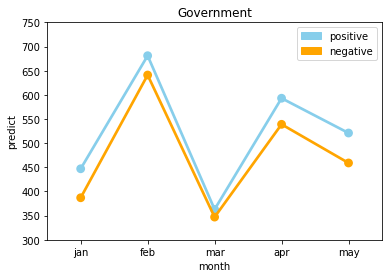

In [879]:
import seaborn as sns
import matplotlib.patches as mpatches

plt.title('Government')
sns.pointplot(x='month', y='predict', data = 정부_긍정, color = 'skyblue', label = 'positive')
positive = mpatches.Patch(color='skyblue', label='positive')
plt.legend(handles = [positive])

sns.pointplot(x='month', y='predict', data = 정부_부정, color = 'orange', label = 'negative')
negative = mpatches.Patch(color='orange', label='negative')
plt.legend(handles = [positive, negative])

plt.ylim(300, 750)